# Execução do algoritmo

In [ ]:
!pip install liwc
import pandas as pd
import matplotlib.pyplot as plt
import liwc
import re
from collections import Counter
from google.colab import drive
import numpy as np
import seaborn as sns
import scipy.stats as stats

drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/red_pill_analises/'
caminho_comentatios = 'data_base/dados_limpos/comentarios_limpos.csv'
caminho_canais = 'data_base/dados_limpos/canais_limpos.csv'
caminho_videos = 'data_base/dados_limpos/videos_limpos.csv'

df_canais = pd.read_csv(folder_path + caminho_canais)
df_videos = pd.read_csv(folder_path + caminho_videos)
df_comentarios = pd.read_csv(folder_path + caminho_comentatios)

Mounted at /content/drive


###Análise do LIWC


*   Def. das funções;
*   Carrega o dicionário LIWC;
*   Execução;



In [ ]:
# Função de tokenização do texto
def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

# Lista de todas as categorias que você deseja analisar
categories_to_analyze = [
    'posemo', 'negemo', 'affect', 'family', 'social', 'power', 'achievement',
    'material', 'cognitive', 'risk', 'body', 'health', 'time', 'space', 'religion',
    'death', 'ingest', 'sexual', 'money', 'swear', 'anger', 'sad', 'anx'
]

# Função para realizar a análise de sentimentos usando LIWC
def analyze_sentiment_liwc(text, parse):
    text_tokens = tokenize(text)
    categories = Counter(category for token in text_tokens for category in parse(token))

    # Inicializando um dicionário para armazenar as contagens
    results = {}
    for category in categories_to_analyze:
        results[category] = categories.get(category, 0)

    # Cálculo da polaridade a partir das categorias
    positive_words = results.get('posemo', 0)  # Sentimentos positivos
    negative_words = results.get('negemo', 0)  # Sentimentos negativos
    affect_words = results.get('affect', 0)  # Sentimentos emocionais gerais

    # Cálculo da polaridade e subjetividade
    polarity = (positive_words - negative_words) / (positive_words + negative_words + 1e-5)  # Para evitar divisão por zero
    subjectivity = affect_words / (len(text.split()) + 1e-5)  # Proporção de palavras afetivas

    # Adiciona polaridade e subjetividade ao dicionário de resultados
    results['polarity'] = polarity
    results['subjectivity'] = subjectivity

    # Adiciona também as colunas booleanas para cada categoria, indicando se é maior que zero
    for category in categories_to_analyze:
        proportion = results[category] / (len(text.split()) + 1e-5)
        results[f'{category}_positive_count'] = proportion

    return results

# Carregar o dicionário LIWC
parse, category_names = liwc.load_token_parser(folder_path + 'data_base/modelos/Brazilian_Portuguese_LIWC2007_Dictionary.dic')

# Aplicar a função em cada linha da coluna 'text' e armazenar os resultados em um novo DataFrame
analysis_results = df_videos['text'].apply(lambda text: analyze_sentiment_liwc(text, parse))

# Expandir os resultados em novas colunas
df_videos = pd.concat([df_videos, analysis_results.apply(pd.Series)], axis=1)

# Plotar gráficos com dados do servidor

In [ ]:
!pip install liwc
import pandas as pd
import matplotlib.pyplot as plt
import liwc
import re
from collections import Counter
from google.colab import drive
import numpy as np
import seaborn as sns
import scipy.stats as stats

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

folder_path = '/content/drive/MyDrive/red_pill_analises/'
#caminho_comentatios = 'data_base/resultados/comentarios_com_liwc.csv'
caminho_canais = 'data_base/resultados/canais_com_liwc.csv'
caminho_videos = 'data_base/resultados/videos_com_liwc.csv'

#df_canais = pd.read_csv(folder_path + caminho_canais)
df_videos = pd.read_csv(folder_path + caminho_videos)
#df_comentarios = pd.read_csv(folder_path + caminho_comentatios)

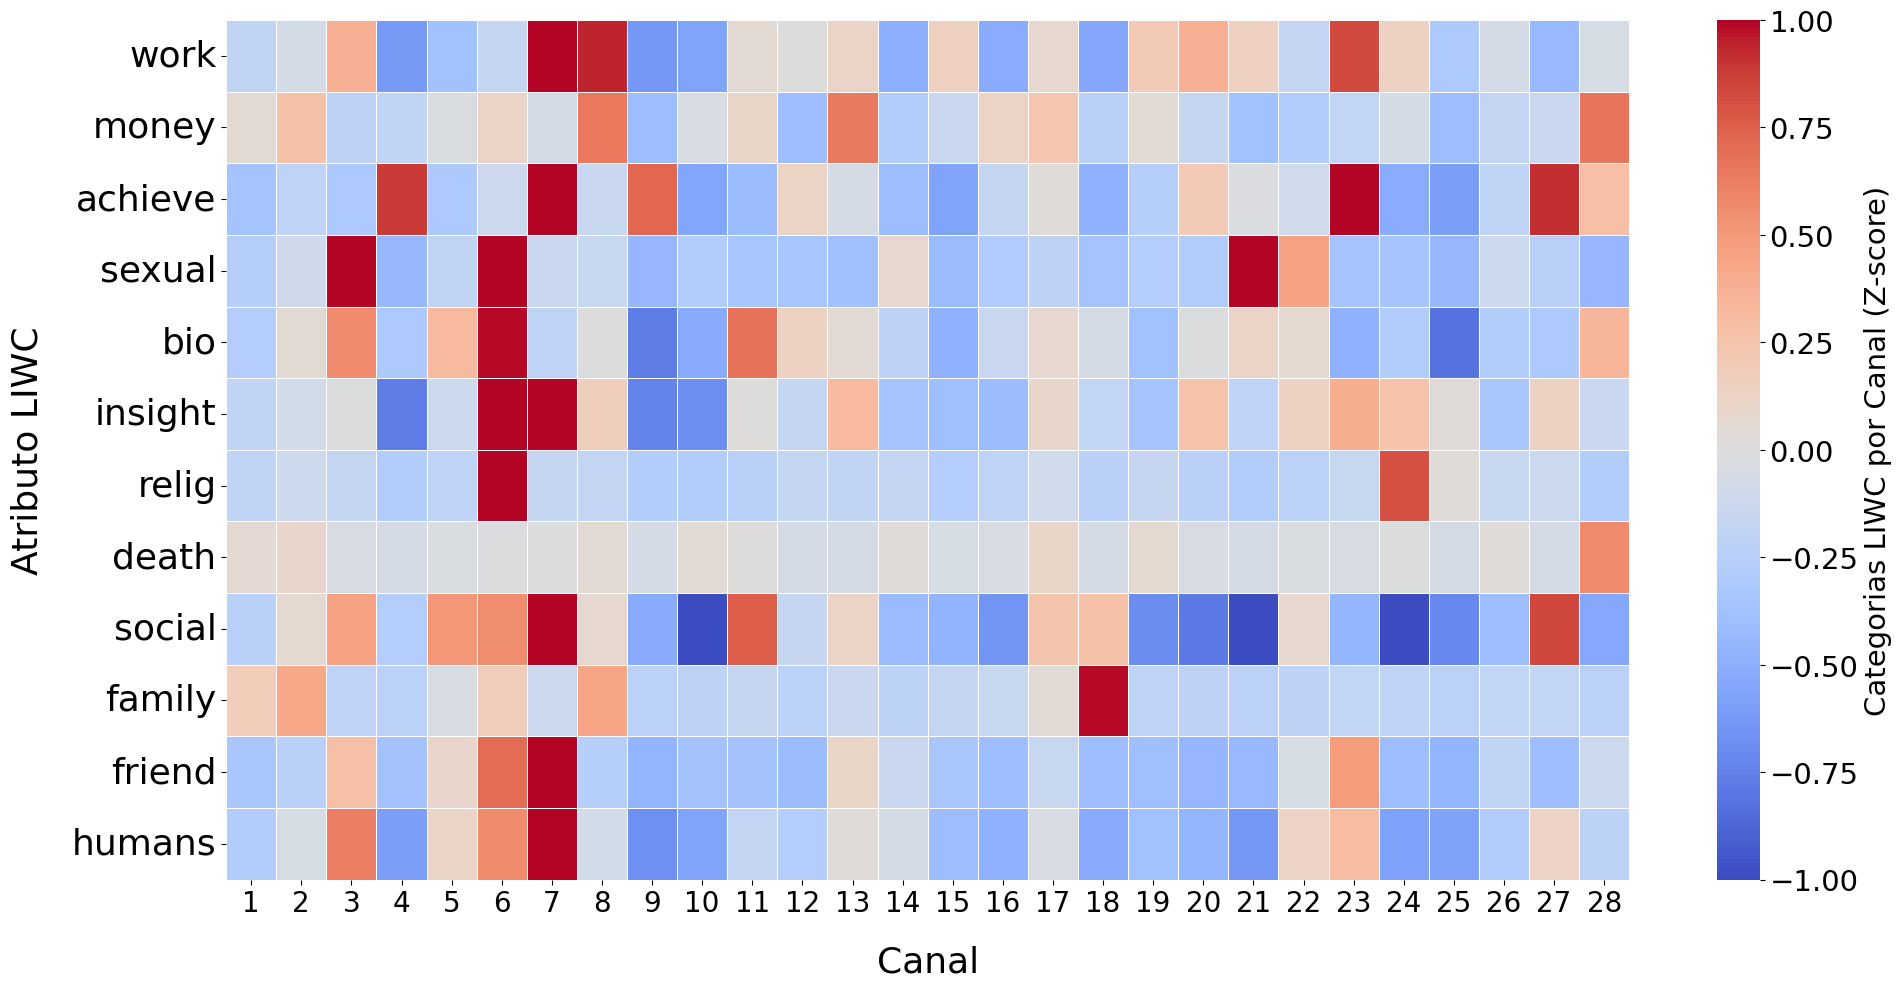

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Atualiza fonte
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 10,
    'axes.titlesize': 21,
    'axes.labelsize': 21,
    'xtick.labelsize': 18,
    'ytick.labelsize': 21,
    'legend.fontsize': 20,
})

def plot_multiple_zscore_heatmaps(texts_df):
    # Mapeamento das categorias LIWC para português
    category_mapping = {
        "work_zscore": "work",
        "money_zscore": "money",
        "achieve_zscore": "achieve",
        "sexual_zscore": "sexual",
        "bio_zscore": "bio",
        "insight_zscore": "insight",
        "relig_zscore": "relig",
        "death_zscore": "death",
        "social_zscore": "social",
        "family_zscore": "family",
        "friend_zscore": "friend",
        "humans_zscore": "humans"
    }

    categories_to_plot_z = list(category_mapping.keys())


    # Verifica se a coluna 'id_canal_anonimizado' está presente
    if 'id_canal_anonimizado' not in texts_df.columns:
        raise ValueError("A coluna 'id_canal_anonimizado' é necessária no DataFrame.")

    # Ordena os canais numericamente
    topics = sorted(texts_df['id_canal_anonimizado'].unique(), key=lambda x: int(x.replace("canal_", "")))

    # Calcula a média dos z-scores por canal
    counts_matrix_z = {
        category: texts_df.groupby('id_canal_anonimizado')[category].mean()
        for category in categories_to_plot_z
        if category in texts_df.columns
    }
    df_zscore = pd.DataFrame(counts_matrix_z)

    # Reordena os canais (colunas)
    df_zscore = df_zscore.T[topics]

    # Remove o sufixo "_zscore" do índice (categorias) e mapeia para português
    df_zscore.index = [category_mapping.get(cat, cat.replace("_zscore", "")) for cat in df_zscore.index]


    # Lista de limites para o eixo de cores
    zscore_ranges = [1]

    # Cria um gráfico para cada intervalo de z-score
    for z in zscore_ranges:
        plt.figure(figsize=(20, 10))
        ax = sns.heatmap(
            df_zscore,
            cmap="coolwarm",
            center=0,
            vmin=-z,
            vmax=z,
            annot=False,
            linewidths=0.5,
            cbar_kws={'label': f'Categorias LIWC por Canal (Z-score)'},
            xticklabels=[topic.replace("canal_", "") for topic in topics],
        )

        plt.yticks(rotation=0, fontsize=26)
        plt.xticks(rotation=0, ha="center", fontsize=20)
        plt.ylabel("Atributo LIWC", fontsize=26, labelpad=20)
        plt.xlabel("Canal", fontsize=26, labelpad=20)

        # Get the colorbar object and set the label with padding
        cbar = ax.collections[0].colorbar
        #cbar.set_label(f'Z-Score Médio por Canal (range: -{z} a {z})', labelpad=20) # Set label with padding


        # plt.title(f"Heatmap de Z-Scores com Intervalo de -{z} a {z}", fontsize=28)
        plt.tight_layout()
        plt.show()

plot_multiple_zscore_heatmaps(df_videos)

In [ ]:
plot_multiple_zscore_heatmaps(df_comentarios)

KeyError: "None of [Index(['canal_1', 'canal_2', 'canal_3', 'canal_4', 'canal_5', 'canal_6',\n       'canal_7', 'canal_8', 'canal_9', 'canal_10', 'canal_11', 'canal_12',\n       'canal_13', 'canal_14', 'canal_15', 'canal_16', 'canal_17', 'canal_18',\n       'canal_19', 'canal_20', 'canal_21', 'canal_22', 'canal_23', 'canal_24',\n       'canal_25', 'canal_26', 'canal_27', 'canal_28'],\n      dtype='object')] are in the [columns]"

In [ ]:
# # Filtrar apenas os valores estatisticamente significativos
# alpha = 0.05
# significant_results = results_df[results_df["p-valor"] < alpha]
# significant_results = significant_results[significant_results["Comparação"] == 'channel_id']
# significant_results

In [ ]:
categories_to_plot_z = [
    "work_zscore", "money_zscore", "achieve_zscore",
    "sexual_zscore", "bio_zscore",
    "insight_zscore", "relig_zscore", "death_zscore",
    "social_zscore", "family_zscore", "friend_zscore", "humans_zscore"
]

# Calculate the mean z-score for each category per channel
mean_zscores = df_videos.groupby('id_canal_anonimizado')[categories_to_plot_z].mean()

# Find the channel with the highest and lowest mean z-score for each category
max_zscores = mean_zscores.idxmax().rename('Highest Z-Score Channel')
min_zscores = mean_zscores.idxmin().rename('Lowest Z-Score Channel')

# Get the corresponding z-score values
max_values = mean_zscores.max().rename('Highest Z-Score Value')
min_values = mean_zscores.min().rename('Lowest Z-Score Value')


# Combine the results into a single DataFrame
summary_zscores = pd.concat([max_zscores, max_values, min_zscores, min_values], axis=1)

# Round the numerical columns to 1 decimal place
summary_zscores[['Highest Z-Score Value', 'Lowest Z-Score Value']] = summary_zscores[['Highest Z-Score Value', 'Lowest Z-Score Value']].round(1)


# Remove the "_zscore" suffix from the index for better readability
summary_zscores.index = [cat.replace("_zscore", "") for cat in summary_zscores.index]

print("Summary of Highest and Lowest Z-Scores per LIWC Category (Videos):")
display(summary_zscores)

In [ ]:
import pandas as pd

def calcular_media_categorias_absolutas(df):
    # Lista com os nomes originais das categorias (valores absolutos, não z-scores)
    categorias_absolutas = [
        "work", "money", "achieve", "sexual", "bio",
        "insight", "relig", "death", "social",
        "family", "friend", "humans"
    ]

    # Filtra apenas as colunas relevantes
    df_filtrado = df[categorias_absolutas]

    # Calcula a média por categoria
    medias = df_filtrado.mean().sort_values(ascending=False)

    # Exibe a tabela ordenada
    display(medias)

In [ ]:
calcular_media_categorias_absolutas(df_videos)

In [ ]:
# Especifique a categoria LIWC (sem "_zscore") que você deseja analisar
selected_category = 'insight' # Altere para a categoria desejada

zscore_column = f'{selected_category}_zscore'

# Certifique-se de que a célula que define 'mean_zscores' (célula 67b9cd47)
# foi executada antes de executar esta célula.
if 'mean_zscores' not in locals():
    print("Erro: 'mean_zscores' não está definido. Por favor, execute a célula 67b9cd47 primeiro.")
else:
    if zscore_column not in mean_zscores.columns:
        print(f"Categoria '{selected_category}' não encontrada nos dados de z-score médio.")
        print(f"Categorias disponíveis: {[col.replace('_zscore', '') for col in mean_zscores.columns]}")
    else:
        # Ordenar canais pelo z-score médio para a categoria especificada em ordem decrescente
        ranked_channels = mean_zscores[zscore_column].sort_values(ascending=False)

        print(f"Canais ordenados por Z-Score Médio para a categoria '{selected_category}':")
        display(ranked_channels)

In [ ]:
# Calculate the standard deviation of the mean z-scores across categories for each channel
std_dev_zscores = mean_zscores.std(axis=1).sort_values(ascending=False)

# Display the channels sorted by standard deviation
print("Channels sorted by standard deviation of mean z-scores across LIWC categories (Videos):")
display(std_dev_zscores)

In [ ]:
def rank_channels_by_liwc_category(category_name, mean_zscores_df):
    """
    Ranks channels based on their mean z-score for a given LIWC category.

    Args:
        category_name (str): The name of the LIWC category (without "_zscore").
        mean_zscores_df (pd.DataFrame): DataFrame containing mean z-scores per channel
                                        and category, with channel IDs as index.
    """
    zscore_column = f'{category_name}_zscore'

    if zscore_column not in mean_zscores_df.columns:
        print(f"Categoria '{category_name}' não encontrada nos dados de z-score médio.")
        print(f"Categorias disponíveis: {[col.replace('_zscore', '') for col in mean_zscores_df.columns]}")
        return

    # Sort channels by the mean z-score for the specified category in descending order
    ranked_channels = mean_zscores_df[zscore_column].sort_values(ascending=False)

    print(f"Canais ordenados por Z-Score Médio para a categoria '{category_name}':")
    display(ranked_channels)

In [ ]:
calcular_media_categorias_absolutas(df_comentarios)